In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import shap

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 100
plt.style.use('seaborn')
shap.initjs()

In [3]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
            'marital_status', 'occupation', 'relationship',
            'race', 'sex', 'capital_gain', 'capital_loss',
            'hours_per_week', 'native_country', 'income']

data_df = pd.read_csv("adult.data", header=None, skipinitialspace=True)
data_df.columns = columns
display(data_df.head())

test_df = pd.read_csv("adult.test", header=None, skiprows=1, skipinitialspace=True)
test_df.columns = columns
# Fixup income column
test_df['income'] = test_df['income'].str.rstrip('.')
display(test_df.head(2))

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K


In [4]:
data_df["income_num"] = data_df["income"].apply(lambda v: 1 if v == '>50K' else 0)
display(data_df["income_num"].value_counts())
test_df["income_num"] = test_df["income"].apply(lambda v: 1 if v == '>50K' else 0)
display(test_df["income_num"].value_counts())

0    24720
1     7841
Name: income_num, dtype: int64

0    12435
1     3846
Name: income_num, dtype: int64

In [5]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
cat_feature_names= ["workclass", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]
num_feature_names= ["age", "education_num", "capital_loss", "capital_gain", "hours_per_week"]

lb_enc = LabelBinarizer(sparse_output=False)
oh_enc = OneHotEncoder(sparse=False)
oh_enc.fit(data_df[cat_feature_names])
#display(pd.DataFrame(oh_enc.categories_))
oh_enc_feature_names = pd.Series(oh_enc.get_feature_names())
#for i, f in enumerate(oh_enc_feature_names):
for i in range(0, len(cat_feature_names)):
    oh_enc_feature_names = oh_enc_feature_names.str.replace("x{}".format(i), cat_feature_names[i])

data_cf_arr = oh_enc.transform(data_df[cat_feature_names])
display(data_cf_arr.shape)

test_cf_arr = oh_enc.transform(test_df[cat_feature_names])
display(test_cf_arr.shape)

data_enc_df = pd.concat([data_df[num_feature_names], pd.DataFrame(data_cf_arr, columns=oh_enc_feature_names)], axis=1)
data_enc_df.head(2)

test_enc_df = pd.concat([test_df[num_feature_names], pd.DataFrame(test_cf_arr, columns=oh_enc_feature_names)], axis=1)

(32561, 86)

(16281, 86)

In [6]:
from catboost import CatBoostClassifier, Pool
features = [''] * 11
features[0] = "age"       
features[1] = "workclass"       # categorical
features[2] = "education_num"
features[3] = "marital_status"  # categorical
features[4] = "occupation"      # categorical
features[5] = "relationship"    # categorical
features[6] = "race"            # categorical
features[7] = "sex"             # categorical
features[8] = "capital_loss"
features[8] = "capital_gain"
features[9] = "hours_per_week"
features[10] = "native_country" # categorical
cat_features = [1, 3, 4, 5, 6, 7, 10]

display(features)

train_pool = Pool(data_df[features], data_df["income_num"], cat_features=cat_features)
test_pool = Pool(test_df[features], test_df["income_num"],  cat_features=cat_features)

['age',
 'workclass',
 'education_num',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital_gain',
 'hours_per_week',
 'native_country']

In [7]:
cb_model = CatBoostClassifier(silent=True)
cb_model.fit(train_pool)

In [8]:
class_names = [">50K", "<=50K"]

def plot_confusion_matrix(y_true, y_pred, class_names):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred)
    #display(cm)
    # Taken from https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823

    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    #display(cm_df)

    fig = plt.figure()
    heatmap = sns.heatmap(cm_df, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

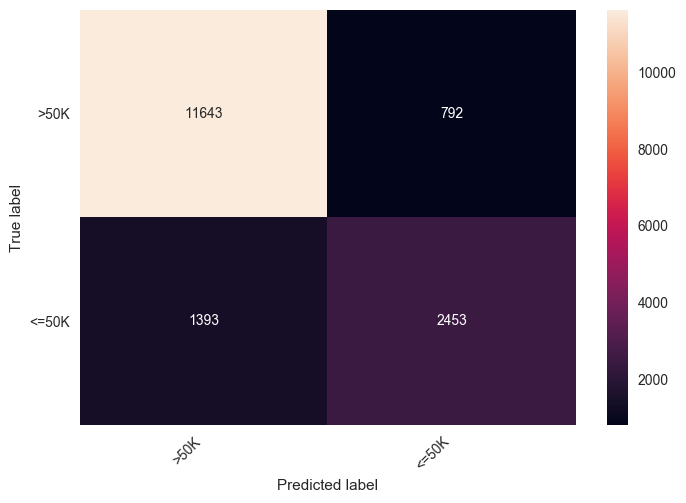

In [9]:
cb_y_pred = cb_model.predict(test_pool, prediction_type='Class')
plot_confusion_matrix(test_df["income_num"], cb_y_pred, class_names)

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(test_df["income_num"], cb_y_pred)
recall = recall_score(test_df["income_num"], cb_y_pred)
print(f"Precision: {precision:.2f}, recall: {recall:2f}")

Precision: 0.76, recall: 0.637806


In [11]:
import xgboost as xgb

dtrain = xgb.DMatrix(data_enc_df, data_df["income_num"])
xgb_model = xgb.train({}, dtrain)

[14:33:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[14:33:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[14:33:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[14:33:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[14:33:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[14:33:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[14:33:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[14:33:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[14:33:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes

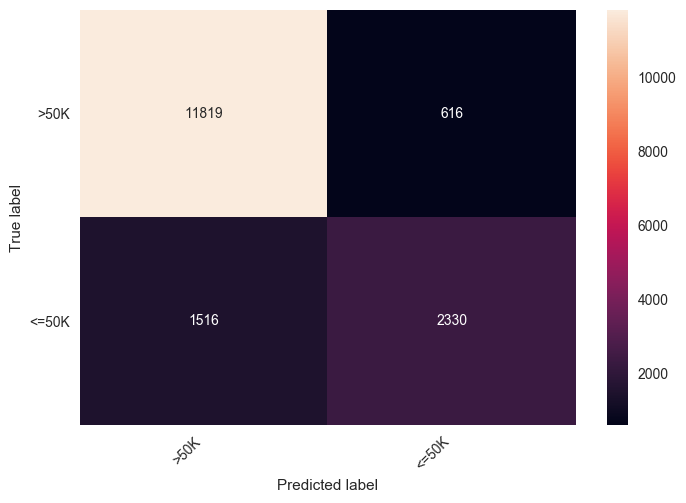

In [12]:
xgb_y_pred = pd.Series(xgb_model.predict(xgb.DMatrix(test_enc_df))).apply(lambda v: 0 if v < 0.5 else 1)
plot_confusion_matrix(test_df["income_num"], xgb_y_pred, class_names)

In [13]:
precision = precision_score(test_df["income_num"], xgb_y_pred)
recall = recall_score(test_df["income_num"], xgb_y_pred)
f1 = f1_score(test_df["income_num"], xgb_y_pred)
print(f"Precision: {precision:.2f}, recall: {recall:2f}, F1 Score: {f1:3f}")

Precision: 0.79, recall: 0.605824, F1 Score: 0.686101


In [14]:
# Future work:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e

# Feature engineering
# https://github.com/aikho/awesome-feature-engineering
# https://github.com/xiaoganghan/awesome-feature-engineering
# https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/
#
# Other analyses of this dataset
# https://www.valentinmihov.com/2015/04/17/adult-income-data-set/

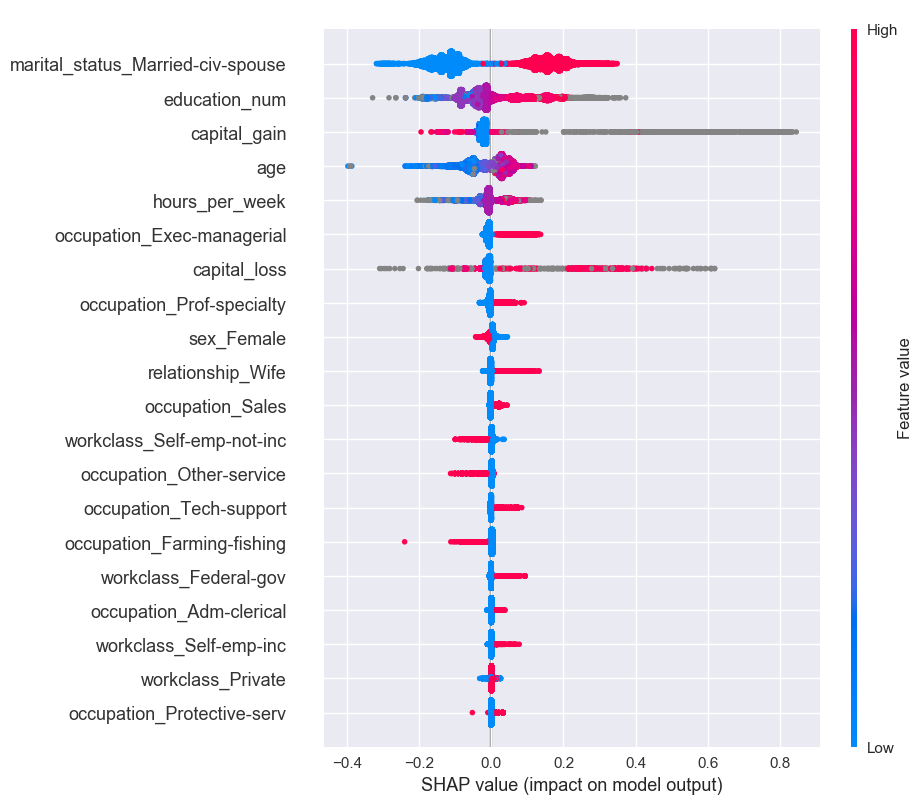

In [15]:
xgb_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_explainer.shap_values(data_enc_df)
#shap.force_plot(xgb_explainer.expected_value, xgb_shap_values[0,:], data_enc_df.iloc[0,:])

shap.summary_plot(xgb_shap_values, data_enc_df)

The model has complex ctrs, so the SHAP values will be calculated approximately.


array([ 0.67539462, -0.16606629,  0.82998362, -0.47417076, -0.25011758,
       -0.72463139, -0.01848662,  0.19932075, -2.07203551, -0.04866134])

age                          39
workclass             State-gov
education_num                13
marital_status    Never-married
occupation         Adm-clerical
relationship      Not-in-family
race                      White
sex                        Male
capital_gain               2174
hours_per_week               40
native_country    United-States
Name: 0, dtype: object

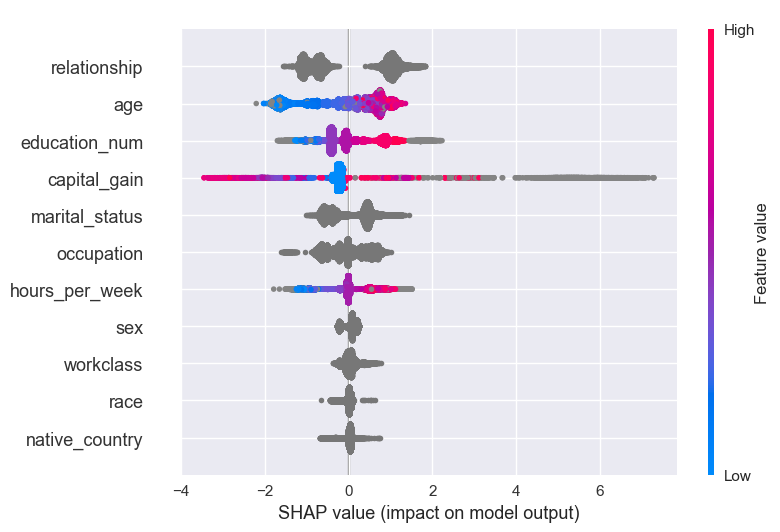

In [16]:
cb_explainer = shap.TreeExplainer(cb_model)
cb_shap_values = cb_explainer.shap_values(train_pool)
display(cb_shap_values[0,:-1])
display(data_df[features].iloc[0,:])

shap.summary_plot(cb_shap_values, data_df[features])